=== INFORME DE ANÁLISIS DE WHALES EN SERIES TEMPORALES ===

1. ESTADÍSTICAS GLOBALES
-----------------------
Período de análisis: 2024-12-30 11:56:46 a 2024-12-30 14:54:50
Número de snapshots temporales: 26
Número de direcciones únicas: 100
Influence Score promedio global: 0.0585
Desviación estándar global: 0.0866

2. TOP WHALES
------------
Dirección: N2C374IRX7HEX2YEQWJBTRSVRHRUV4ZSF76S54WV4COTHRUNYRCI47R3WU
  - Influence Score promedio: 0.6004
  - Máximo Influence Score: 0.6004
  - Transaction Weight promedio: 0.0010
  - Holdings Weight promedio: 1.0000

Dirección: MTCEM5YJJSYGW2RCXYXGE4SXLSPUUEJKQAWG2GUX6CNN72KQ3XPJCM6NOI
  - Influence Score promedio: 0.5223
  - Máximo Influence Score: 0.5223
  - Transaction Weight promedio: 0.0574
  - Holdings Weight promedio: 0.8322

Dirección: GH27QMBSQZF3O6J7SGXQRQMUQD264HNXZ7R6OXDPIOR5XOOE22UBWUXZI4
  - Influence Score promedio: 0.4000
  - Máximo Influence Score: 0.4000
  - Transaction Weight promedio: 1.0000
  - Holdings Weight promedio: 0.00

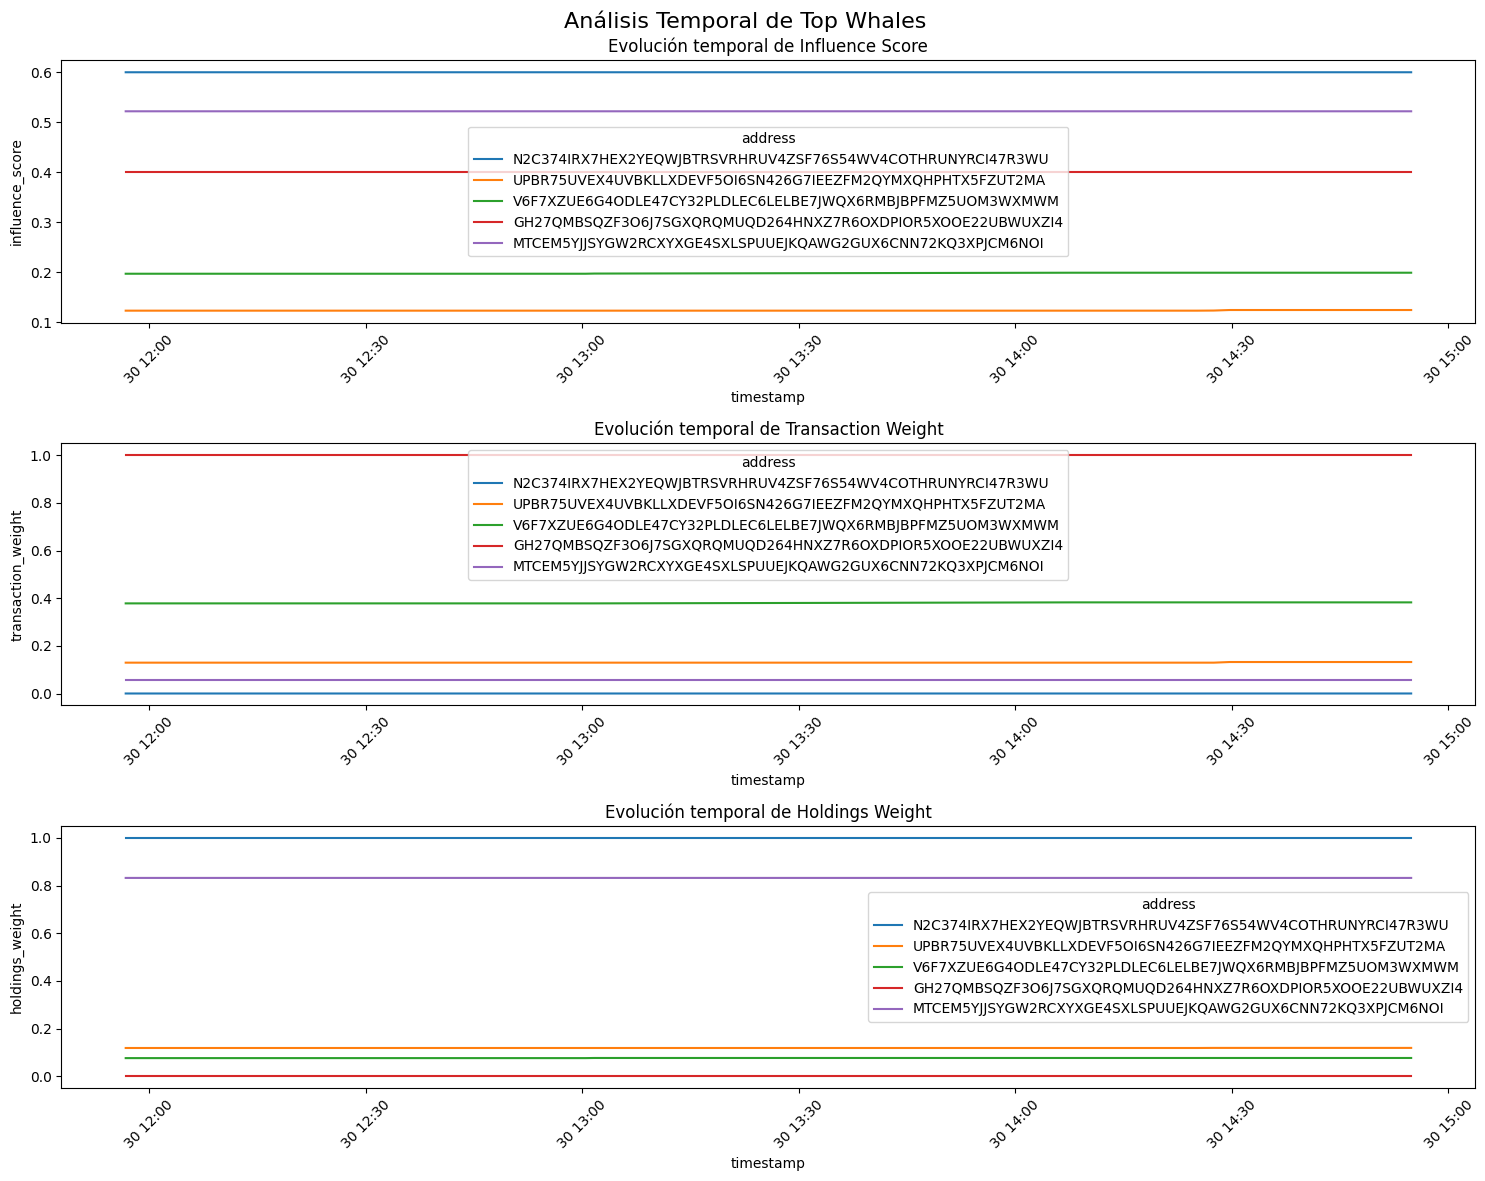

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import logging

class WhaleTimeSeriesAnalyzer:
    def __init__(self):
        self.data = None
        self.top_whales = None
        self.temporal_metrics = None
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)
        
    def load_csv_files(self, file_pattern):
        """
        Carga los archivos CSV y los combina en un DataFrame con series temporales
        """
        dfs = []
        files = sorted(Path('.').glob(file_pattern))
        
        for file in files:
            try:
                # Extraer timestamp del nombre del archivo
                timestamp = datetime.strptime(
                    str(file).split('_')[2:4][0] + '_' + str(file).split('_')[2:4][1].replace('.csv',''),
                    '%Y%m%d_%H%M%S'
                )
                
                # Leer CSV
                df = pd.read_csv(file)
                df['timestamp'] = timestamp
                dfs.append(df)
                
            except Exception as e:
                self.logger.error(f"Error procesando archivo {file}: {str(e)}")
                
        self.data = pd.concat(dfs, ignore_index=True)
        self.data.sort_values('timestamp', inplace=True)
        
        return self
    
    def calculate_temporal_metrics(self):
        """
        Calcula métricas temporales para todo el conjunto de datos
        """
        self.temporal_metrics = {
            'global': {
                'timestamps': self.data['timestamp'].nunique(),
                'unique_addresses': self.data['address'].nunique(),
                'avg_influence_score': self.data['influence_score'].mean(),
                'std_influence_score': self.data['influence_score'].std(),
                'max_influence_score': self.data['influence_score'].max(),
                'min_influence_score': self.data['influence_score'].min()
            }
        }
        
        # Calcular métricas por timestamp
        time_metrics = self.data.groupby('timestamp').agg({
            'influence_score': ['mean', 'std', 'max', 'min'],
            'transaction_weight': ['mean', 'std', 'max', 'min'],
            'holdings_weight': ['mean', 'std', 'max', 'min']
        })
        
        self.temporal_metrics['by_timestamp'] = time_metrics
        
        return self
    
    def identify_top_whales(self, n=5):
        """
        Identifica las top n whales basado en influence_score promedio
        """
        whale_metrics = self.data.groupby('address').agg({
            'influence_score': ['mean', 'std', 'max', 'min'],
            'transaction_weight': ['mean', 'std'],
            'holdings_weight': ['mean', 'std']
        })
        
        # Ordenar por influence_score promedio
        self.top_whales = whale_metrics.sort_values(('influence_score', 'mean'), ascending=False).head(n)
        
        return self
    
    def generate_report(self):
        """
        Genera un informe detallado del análisis
        """
        if self.data is None:
            raise ValueError("No hay datos cargados. Ejecute load_csv_files primero.")
            
        report = []
        report.append("=== INFORME DE ANÁLISIS DE WHALES EN SERIES TEMPORALES ===\n")
        
        # 1. Estadísticas Globales
        report.append("1. ESTADÍSTICAS GLOBALES")
        report.append("-----------------------")
        report.append(f"Período de análisis: {self.data['timestamp'].min()} a {self.data['timestamp'].max()}")
        report.append(f"Número de snapshots temporales: {self.temporal_metrics['global']['timestamps']}")
        report.append(f"Número de direcciones únicas: {self.temporal_metrics['global']['unique_addresses']}")
        report.append(f"Influence Score promedio global: {self.temporal_metrics['global']['avg_influence_score']:.4f}")
        report.append(f"Desviación estándar global: {self.temporal_metrics['global']['std_influence_score']:.4f}\n")
        
        # 2. Top Whales
        report.append("2. TOP WHALES")
        report.append("------------")
        for addr in self.top_whales.index:
            report.append(f"Dirección: {addr}")
            report.append(f"  - Influence Score promedio: {self.top_whales.loc[addr, ('influence_score', 'mean')]:.4f}")
            report.append(f"  - Máximo Influence Score: {self.top_whales.loc[addr, ('influence_score', 'max')]:.4f}")
            report.append(f"  - Transaction Weight promedio: {self.top_whales.loc[addr, ('transaction_weight', 'mean')]:.4f}")
            report.append(f"  - Holdings Weight promedio: {self.top_whales.loc[addr, ('holdings_weight', 'mean')]:.4f}\n")
        
        # 3. Análisis Temporal
        report.append("3. ANÁLISIS TEMPORAL")
        report.append("-------------------")
        temporal_stats = self.temporal_metrics['by_timestamp']
        report.append("Estadísticas por timestamp (promedios):")
        report.append(f"  - Influence Score: {temporal_stats['influence_score']['mean'].mean():.4f}")
        report.append(f"  - Transaction Weight: {temporal_stats['transaction_weight']['mean'].mean():.4f}")
        report.append(f"  - Holdings Weight: {temporal_stats['holdings_weight']['mean'].mean():.4f}\n")
        
        # 4. Correlaciones
        report.append("4. CORRELACIONES")
        report.append("---------------")
        correlations = self.data[['influence_score', 'transaction_weight', 'holdings_weight']].corr()
        for i in correlations.index:
            for j in correlations.columns:
                if i != j:
                    report.append(f"Correlación {i} vs {j}: {correlations.loc[i,j]:.4f}")
        
        return "\n".join(report)
    
    def plot_temporal_analysis(self):
        """
        Genera visualizaciones del análisis temporal
        """
        if self.top_whales is None:
            self.identify_top_whales()
            
        # Crear subplots para cada métrica
        fig, axes = plt.subplots(3, 1, figsize=(15, 12))
        fig.suptitle('Análisis Temporal de Top Whales', fontsize=16)
        
        metrics = ['influence_score', 'transaction_weight', 'holdings_weight']
        titles = ['Influence Score', 'Transaction Weight', 'Holdings Weight']
        
        for idx, (metric, title) in enumerate(zip(metrics, titles)):
            # Filtrar datos para top whales
            top_addresses = self.top_whales.index.tolist()
            plot_data = self.data[self.data['address'].isin(top_addresses)]
            
            # Crear plot
            sns.lineplot(
                data=plot_data,
                x='timestamp',
                y=metric,
                hue='address',
                ax=axes[idx]
            )
            
            axes[idx].set_title(f'Evolución temporal de {title}')
            axes[idx].tick_params(axis='x', rotation=45)
            
        plt.tight_layout()
        return fig

# Ejemplo de uso
def main():
    # Inicializar analizador
    analyzer = WhaleTimeSeriesAnalyzer()
    
    # Cargar datos
    analyzer.load_csv_files('whale_analysis_*.csv')
    
    # Calcular métricas temporales
    analyzer.calculate_temporal_metrics()
    
    # Identificar top whales
    analyzer.identify_top_whales(n=5)
    
    # Generar informe
    report = analyzer.generate_report()
    
    # Imprimir informe
    print(report)
    
    # Generar visualización
    fig = analyzer.plot_temporal_analysis()
    plt.show()

if __name__ == "__main__":
    main()